In [233]:
from keras.datasets import mnist, cifar10 # Mnist - набор рукописных цифр, cifar10 - изображения объектов 1-ти классов
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply # Базовые слои keras
from keras.layers.advanced_activations import LeakyReLU # LeakyReLU - функция активации
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv1D, Conv2DTranspose # Сверточные слои keras
from keras.models import Sequential, Model # Формат модели keras
from tensorflow.keras.optimizers import Adam # Оптимизатор 

import matplotlib.pyplot as plt

import numpy as np
import os
import time, random
from tensorflow.keras.preprocessing import image
from createTrain import createTrains
from PIL import ImageFile
import cv2

In [310]:
no_path = './wm-nowm/train/no-watermark/'
water_path = './wm-nowm/train/watermark/'
val_path_water = './wm-nowm/valid/watermark/'
val_path_nowater = './wm-nowm/valid/no-watermark/'

H = 64
W = 64
C = 256
batch_size = 21
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [311]:
xTrain, yTrain = createTrains(no_path, water_path, W, H)
xVal, yVal = createTrains(val_path_nowater, val_path_water, W, H)

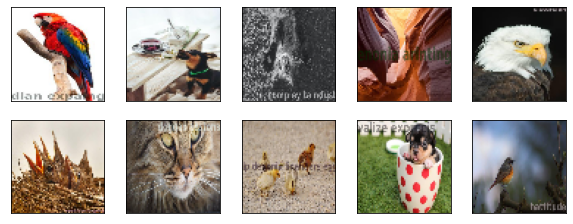

In [312]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(xTrain[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

In [313]:
img_shape = (H, W, 3)
optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [314]:
def create_ConvGenerator(): # Функция создания генератора
  generator = Sequential() # Инициализируем модель generator


  generator.add(Conv2D(2, (3,3), padding="same", input_shape=img_shape))
  generator.add(BatchNormalization())
  generator.add(MaxPooling2D())
  generator.add(Conv2D(4, (3,3), padding="same"))
  generator.add(BatchNormalization())
  generator.add(MaxPooling2D())
  generator.add(Flatten())
  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  generator.add(Reshape(img_shape)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows, img_cols, channels))


  noise = Input(shape=img_shape) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  
  img = generator(noise) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise

  print("info")

  print("info")

  generator = Model(noise, img) # создаем модель generator (входные данные: noise, выходные данные: img)

  return generator # Функция возвращаем generator

In [315]:
def create_discriminator(): # Функция создания дискриминатора
  discriminator = Sequential() # Инициализируем модель discriminator

  discriminator.add(Flatten(input_shape=img_shape)) # Создаем слой Flatten (размерность входных данных = (img_rows, img_cols, channels), размерность выходных данных = img_rows * img_cols * channels )
  discriminator.add(Dense(512))  # Добавляем Dense-слой на 512 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(256)) # Добавляем Dense-слой на 256 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  discriminator = Model(img, validity) # Создаем модель discriminator (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
  
  discriminator.trainable = False  # Замораживаем обучение дискриматора 

  return discriminator # Функция возвращает discriminator

In [316]:
dis = create_discriminator()
dis.summary()


Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential_70 (Sequential)  (None, 1)                 6423553   
                                                                 
Total params: 6,423,553
Trainable params: 0
Non-trainable params: 6,423,553
_________________________________________________________________


In [320]:
import tensorflow as tf
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [321]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [322]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [323]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [317]:
def sampleConv_images(epoch, gen, latent_dim = img_shape): # Функция печати изображений

  idx = np.random.randint(0, xTrain.shape[0], 10)
  train = xTrain[idx]
  gen_imgs = gen.predict(train) # Предиктим картинку с помощью входной переменной gen
  
  #gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  plt.figure(figsize=(10,10))
  for i in range(10):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(cv2.cvtColor(gen_imgs[i].astype('float32'), cv2.COLOR_BGR2RGB))
  plt.show()

In [326]:
def trainConv(generator, discriminator, epochs=50, batch_size=50, latent_dim= 100): # Функция обучения   
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size

  z = Input(shape=img_shape) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  img = generator(z) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  combined = Model(z, validity) # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy

  sample_interval = 200 # Указываем интервал, через который будем выводить текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  d_loss_fake_list = []
  d_loss_real_list = []

  
  for epoch in range(epochs): 
    # ---------------------
    #  Train Discriminator
    # ---------------------
    idx = np.random.randint(0, xTrain.shape[0], batch_size)
    train = xTrain[idx]
    test = yTrain[idx]
    gen_imgs = generator.predict(train) # Предиктим картинку с помощью входной переменной generator
    # Train the discriminator
    
    d_loss_real = discriminator.train_on_batch(test, valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам

    # ---------------------
    #  Train Generator
    # ---------------------

    g_loss = combined.train_on_batch(train, valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))
    
    print ("Epoch: %d, Dis loss: %f, acc.: %.2f%% [Gen loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе


    d_loss_real_list.append(d_loss_real[0])
    d_loss_fake_list.append(d_loss_fake[0])

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
        
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)): 
        sampleConv_images(epoch, generator, img_shape) # Вызываем функцию sample_images для печати изображений
  
  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()

  return [d_loss_list,g_loss_list,d_acc_list]

info
info


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0, Dis loss: 0.821473, acc.: 10.00% [Gen loss: 12.774048]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


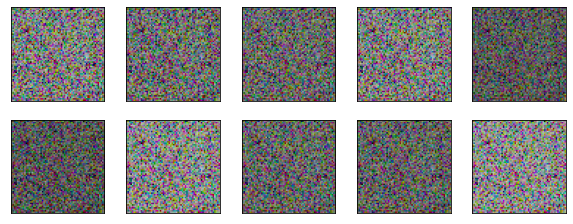

Epoch: 1, Dis loss: 62.194950, acc.: 50.00% [Gen loss: 16.718456]
Epoch: 2, Dis loss: 24.447413, acc.: 0.00% [Gen loss: 18.272949]
Epoch: 3, Dis loss: 6.223518, acc.: 7.00% [Gen loss: 31.799561]
Epoch: 4, Dis loss: 11.952532, acc.: 49.00% [Gen loss: 2.784924]
Epoch: 5, Dis loss: 10.690258, acc.: 47.00% [Gen loss: 13.607057]
Epoch: 6, Dis loss: 10.228657, acc.: 49.00% [Gen loss: 3.454056]
Epoch: 7, Dis loss: 11.570232, acc.: 13.00% [Gen loss: 8.762583]
Epoch: 8, Dis loss: 0.336959, acc.: 85.00% [Gen loss: 12.034284]
Epoch: 9, Dis loss: 0.731885, acc.: 65.00% [Gen loss: 7.595007]
Epoch: 10, Dis loss: 0.344671, acc.: 86.00% [Gen loss: 12.453549]
Epoch: 11, Dis loss: 0.100769, acc.: 95.00% [Gen loss: 10.643463]
Epoch: 12, Dis loss: 2.737237, acc.: 42.00% [Gen loss: 40.984970]
Epoch: 13, Dis loss: 4.229149, acc.: 50.00% [Gen loss: 37.278996]
Epoch: 14, Dis loss: 0.000067, acc.: 100.00% [Gen loss: 20.409941]
Epoch: 15, Dis loss: 0.050014, acc.: 99.00% [Gen loss: 6.762920]
Epoch: 16, Dis loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

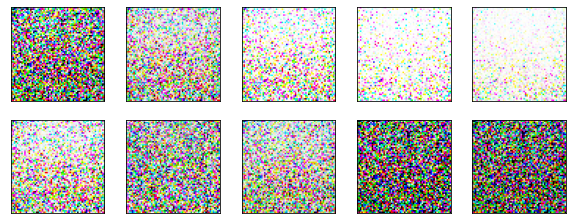

Epoch: 201, Dis loss: 1.294060, acc.: 42.00% [Gen loss: 8.886065]
Epoch: 202, Dis loss: 1.585987, acc.: 50.00% [Gen loss: 4.794081]
Epoch: 203, Dis loss: 1.090374, acc.: 61.00% [Gen loss: 6.918902]
Epoch: 204, Dis loss: 0.947504, acc.: 51.00% [Gen loss: 5.556273]
Epoch: 205, Dis loss: 0.979759, acc.: 46.00% [Gen loss: 7.962193]
Epoch: 206, Dis loss: 1.087693, acc.: 38.00% [Gen loss: 5.596004]
Epoch: 207, Dis loss: 0.870166, acc.: 45.00% [Gen loss: 6.238244]
Epoch: 208, Dis loss: 0.980587, acc.: 40.00% [Gen loss: 6.910454]
Epoch: 209, Dis loss: 1.044672, acc.: 36.00% [Gen loss: 7.838566]
Epoch: 210, Dis loss: 1.317593, acc.: 33.00% [Gen loss: 5.174266]
Epoch: 211, Dis loss: 0.735766, acc.: 59.00% [Gen loss: 7.365027]
Epoch: 212, Dis loss: 1.255932, acc.: 36.00% [Gen loss: 5.600790]
Epoch: 213, Dis loss: 0.608768, acc.: 57.00% [Gen loss: 6.155574]
Epoch: 214, Dis loss: 0.904374, acc.: 50.00% [Gen loss: 5.137556]
Epoch: 215, Dis loss: 0.852337, acc.: 44.00% [Gen loss: 6.203918]
Epoch: 216

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 400, Dis loss: 0.528192, acc.: 72.00% [Gen loss: 3.651184]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


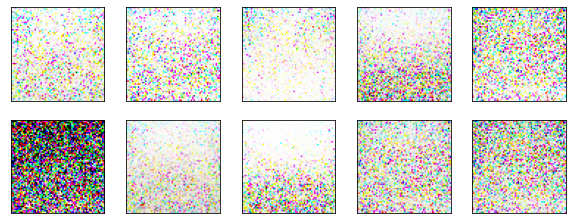

Epoch: 401, Dis loss: 0.772354, acc.: 56.00% [Gen loss: 3.275197]
Epoch: 402, Dis loss: 0.573952, acc.: 68.00% [Gen loss: 3.066851]
Epoch: 403, Dis loss: 0.546684, acc.: 71.00% [Gen loss: 3.324706]
Epoch: 404, Dis loss: 0.508273, acc.: 77.00% [Gen loss: 2.827683]
Epoch: 405, Dis loss: 0.510506, acc.: 77.00% [Gen loss: 2.686156]
Epoch: 406, Dis loss: 0.429229, acc.: 82.00% [Gen loss: 3.485050]
Epoch: 407, Dis loss: 0.569850, acc.: 71.00% [Gen loss: 2.691365]
Epoch: 408, Dis loss: 0.504543, acc.: 74.00% [Gen loss: 3.157892]
Epoch: 409, Dis loss: 0.425092, acc.: 79.00% [Gen loss: 3.302173]
Epoch: 410, Dis loss: 0.676777, acc.: 64.00% [Gen loss: 3.599217]
Epoch: 411, Dis loss: 0.732554, acc.: 65.00% [Gen loss: 2.820492]
Epoch: 412, Dis loss: 0.511784, acc.: 76.00% [Gen loss: 3.186507]
Epoch: 413, Dis loss: 0.649593, acc.: 62.00% [Gen loss: 3.325908]
Epoch: 414, Dis loss: 0.536225, acc.: 72.00% [Gen loss: 2.867776]
Epoch: 415, Dis loss: 0.530675, acc.: 75.00% [Gen loss: 3.199641]
Epoch: 416

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 499, Dis loss: 0.473368, acc.: 77.00% [Gen loss: 2.848775]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


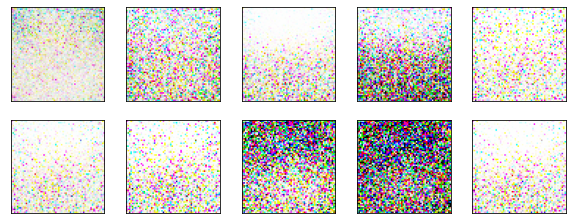

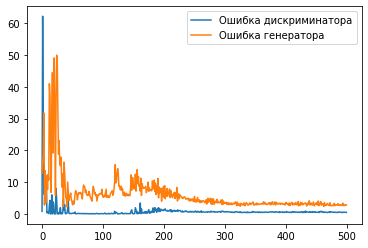

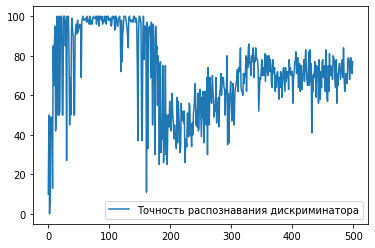

In [328]:
generator = create_ConvGenerator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
history_Conv = trainConv(generator, discriminator, 500) # Вызываем функцию train с параметрами, generator, discriminator, 1000 (1000 - количество эпох)